<a href="https://colab.research.google.com/github/fluderm/Fellowship.ai/blob/main/IMDB_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The following is my attempt at the IMDB sentiment analysis challenge by fellowship.ai.
 
Thank you very much for your time looking through my notebook.
 
Rmk: In academia (theoretical physics) it is standard practice to write 'we' even for single author papers. In the following, I've used this terminology (as it is more natural to me), but I emphasize that everything presented here is done solely by myself and without help from anyone else.


# Download IMDB dataset

We start by loading the data.

In [ ]:
import sys
assert sys.version_info >= (3, 5)

if "google.colab" in sys.modules:
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers

import numpy as np
import os
import sklearn
import pandas as pd
import tensorflow as tf

from collections import Counter

from tensorflow import keras

if not tf.config.list_physical_devices('GPU'):
    print("No GPU")

np.random.seed(42)
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers

from matplotlib import pyplot as plt
import random


     |████████████████████████████████| 1.1 MB 15.0 MB/s 
     |████████████████████████████████| 5.8 MB 14.9 MB/s 
     |████████████████████████████████| 182 kB 89.9 MB/s 
     |████████████████████████████████| 7.6 MB 61.1 MB/s 


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 25.7M/25.7M [00:01<00:00, 35.4MB/s]
100% 25.7M/25.7M [00:01<00:00, 22.0MB/s]


In [ ]:
! unzip imdb-dataset-of-50k-movie-reviews

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
all_data=pd.read_csv('IMDB Dataset.csv')

# EDA:

We now perform some basic exploratory data analysis. The IMDB dataset is a relatively standard dataset, so there is actually not too much to explore here, but it is still important to understand various features.

The reviews are in html format, and we extract the relevant information by stripping formatting etc. (see below).

In [ ]:
# Count the number of positive and negative sentiments.

all_data.groupby(['sentiment'])['sentiment'].count()

sentiment
negative    25000
positive    25000
Name: sentiment, dtype: int64

In [ ]:
def all_words(X):
  X=tf.strings.regex_replace(X,b"<br\\s*/?>",b" ")
  X=tf.strings.regex_replace(X,b"[^a-zA-Z'0-9]", b" ")
  X=tf.strings.regex_replace(X,b"'"," ")
  X=tf.strings.split(X)
  return X

lengths_pos = all_words(all_data.loc[all_data.sentiment=='positive']['review']).nested_row_lengths()[0].numpy()
lengths_neg = all_words(all_data.loc[all_data.sentiment=='negative']['review']).nested_row_lengths()[0].numpy()


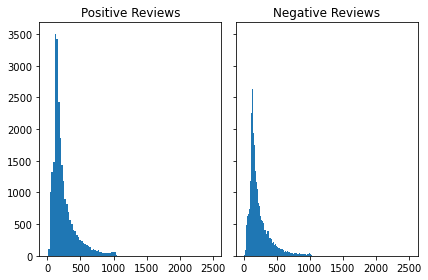

Positive reviews: 
Average length: 237.03616,
Standard deviation: 180.42104237714182,
Longest/Shortest review: (2505, 10),
Nr of reviews over 1000/500/200/100: [124, 2195, 10481, 21740].
-----------------------------------------
Negative reviews: 
Average length: 234.08876,
Standard deviation: 168.0129804558636,
Longest/Shortest review: (1552, 6),
Nr of reviews over 1000/500/200/100: [99, 1873, 10543, 22268].
-----------------------------------------
According to the Kolmogorov-Smirnov test, p-value=1.22e-07, the two statistics are not identical.


In [ ]:
# Sentence length

from scipy.stats import ks_2samp

n_bins = 100

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, tight_layout=True);

axs[0].hist(lengths_pos, bins=n_bins);
axs[0].title.set_text("Positive Reviews")

axs[1].hist(lengths_neg, bins=n_bins);
axs[1].title.set_text("Negative Reviews")

plt.show()

print(f'Positive reviews: \n\
Average length: {np.mean(lengths_pos)},\n\
Standard deviation: {np.std(lengths_pos)},\n\
Longest/Shortest review: {max(lengths_pos),min(lengths_pos)},\n\
Nr of reviews over 1000/500/200/100: {[len(np.where(lengths_pos>i)[0]) for i in [1000,500,200,100]]}.')
print('-----------------------------------------')
print(f'Negative reviews: \n\
Average length: {np.mean(lengths_neg)},\n\
Standard deviation: {np.std(lengths_neg)},\n\
Longest/Shortest review: {max(lengths_neg),min(lengths_neg)},\n\
Nr of reviews over 1000/500/200/100: {[len(np.where(lengths_neg>i)[0]) for i in [1000,500,200,100]]}.')
print('-----------------------------------------')
print(f'According to the Kolmogorov-Smirnov test,\
 p-value={ks_2samp(lengths_pos,lengths_neg)[1]:1.3g},\
 the two statistics are not identical.')

### Conclusions I:



*   Very few reviews are longer than 500 words.
*   The length distribution of positive and negative reviews is quite different. In particular, negative reviews are on average shorter and less spread out than positive reviews.



In [ ]:
pos_words = all_words(all_data.loc[all_data.sentiment=='positive']['review']).values.numpy()
neg_words = all_words(all_data.loc[all_data.sentiment=='negative']['review']).values.numpy()

In [ ]:
pos_words_dict = Counter()
pos_words_dict.update(pos_words)
neg_words_dict = Counter()
neg_words_dict.update(neg_words)

In [ ]:
# Top postive/negative words within 2000 most common words
# appearing in all reviews

tog = pos_words_dict+neg_words_dict

pos_score_dict=Counter()
for w,_ in tog.most_common()[:2000]:
  pos_score_dict[w]=pos_words_dict[w]/tog[w]

neg_score_dict=Counter()
for w,_ in tog.most_common()[:2000]:
  neg_score_dict[w]=neg_words_dict[w]/tog[w]

print(f'Positive words: \
{[x for x,y in pos_score_dict.most_common()[:5]]}\n\
Percentage:     ', end='')
print(['{:.3f}'.format(y) for x,y in pos_score_dict.most_common()[:5]])
print('-----------------------------------------')
print(f'Negative words: \
{[x for x,_ in neg_score_dict.most_common()[:5]]}\n\
Percentage:     ', end='')
print(['{:.3f}'.format(y) for _,y in neg_score_dict.most_common()[:5]])

Positive words: [b'wonderfully', b'beautifully', b'superb', b'outstanding', b'touching']
Percentage:     ['0.880', '0.866', '0.855', '0.836', '0.835']
-----------------------------------------
Negative words: [b'waste', b'worst', b'redeeming', b'awful', b'poorly']
Percentage:     ['0.938', '0.915', '0.911', '0.910', '0.905']


In [ ]:
all_words_per_sentence = all_words(all_data['review'])

In [ ]:
nr_of_extreme_words = 10

pos_words = tf.constant([x for x,_ in pos_score_dict.most_common()[:nr_of_extreme_words]])
pos_word_ids = tf.range(nr_of_extreme_words,dtype=tf.int64)
pos_dict_init = tf.lookup.KeyValueTensorInitializer(pos_words,pos_word_ids)
pos_table = tf.lookup.StaticVocabularyTable(pos_dict_init, 1)


neg_words = tf.constant([x for x,_ in neg_score_dict.most_common()[:nr_of_extreme_words]])
neg_word_ids = tf.range(nr_of_extreme_words,dtype=tf.int64)
neg_dict_init = tf.lookup.KeyValueTensorInitializer(neg_words,neg_word_ids)
neg_table = tf.lookup.StaticVocabularyTable(neg_dict_init, 1)

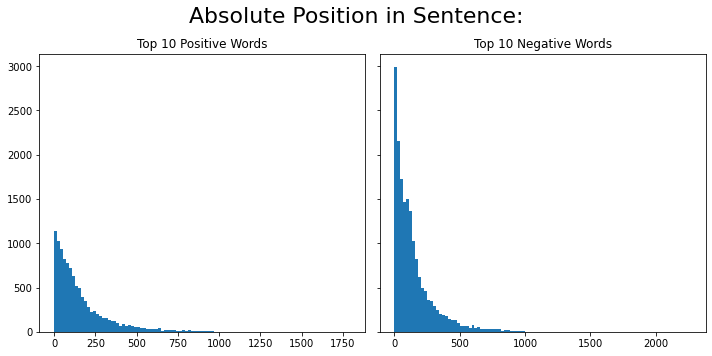

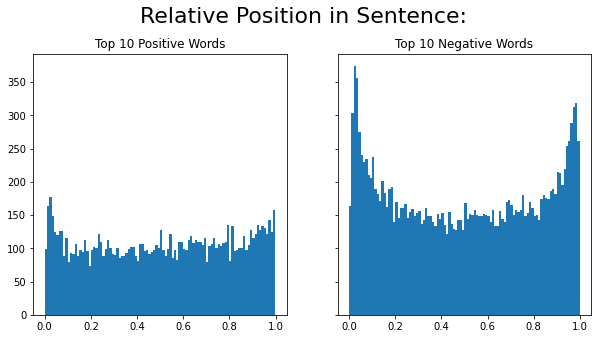

In [ ]:
pos_where = tf.where(pos_table.lookup(all_words_per_sentence)!=nr_of_extreme_words).numpy()
neg_where = tf.where(neg_table.lookup(all_words_per_sentence)!=nr_of_extreme_words).numpy()

n_bins = 100

# ----------- Absolute Position in Sentence -----------

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5));

axs[0].hist(pos_where[:,1], bins=n_bins);
axs[0].title.set_text("Top 10 Positive Words")

axs[1].hist(neg_where[:,1], bins=n_bins);
axs[1].title.set_text("Top 10 Negative Words")

fig.suptitle('Absolute Position in Sentence:',fontsize=22)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

# ----------- Relative Position in Sentence -----------

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5));

axs[0].hist(pos_where[:,1]/pos_table.lookup(all_words_per_sentence).nested_row_lengths()[0].numpy()[pos_where[:,0]], bins=n_bins);
axs[0].title.set_text("Top 10 Positive Words")

axs[1].hist(neg_where[:,1]/neg_table.lookup(all_words_per_sentence).nested_row_lengths()[0].numpy()[neg_where[:,0]], bins=n_bins);
axs[1].title.set_text("Top 10 Negative Words")

fig.suptitle('Relative Position in Sentence:',fontsize=22)
fig.subplots_adjust(top=0.85)
plt.show()

### Conclusions II:
 
 
*  It's interesting (and surprising to me) to see that negative words seem to be skewed towards the beginning and the end of reviews more so than positive words.
*  The positive words are distributed rather uniformly among reviews.
*  We learn that in order to interpret a sentence's sentiment, we should be careful to include all pieces of a review, and in particular the beginning and the end of reviews seem particularly important. This makes intuitive sense as reviewers probably state their overall conclusive feelings right away in the beginning or as a conclusion at the end of their reviews.
*  From the absolute positions in a sentence it seems we are fine cutting off the reviews at around 500 words.
 
We now proceed with discussing various approaches to "learn" sentiments from a given review.


# Approach 0: Naive baseline by counting top 100 good/bad words (82.3% Test accuracy)
 
In this approach we first divide the data into training and test sets. Then we find the top 100 words associated with positive/negative reviews in the training set (essentially the same code as above). Finally, we evaluate the test set on whether we have more positive words or more negative words that appear in a given review (and with randomly selecting positive or negative sentiment on equality). This gives us a naive and basic baseline upon which we will try to improve further below.


In [ ]:
def pos_neg(x):
  return 1 if x=='positive' else 0

X_train0, X_test0, y_train0, y_test0 = train_test_split((all_data['review']), all_data['sentiment'].map(pos_neg),\
                                                    stratify=all_data['sentiment'].map(pos_neg), test_size=0.2, random_state=42)  

Xy_train0=pd.DataFrame(data=X_train0)
Xy_train0['sentiment']=y_train0

p_train = all_words(Xy_train0.loc[Xy_train0.sentiment==1]['review']).values.numpy()
n_train = all_words(Xy_train0.loc[Xy_train0.sentiment==0]['review']).values.numpy()

p_train_words_dict = Counter()
p_train_words_dict.update(p_train)
n_train_words_dict = Counter()
n_train_words_dict.update(n_train)

tog = p_train_words_dict+n_train_words_dict

pos_score_dict=Counter()
for w,_ in tog.most_common()[:2000]:
  pos_score_dict[w]=p_train_words_dict[w]/tog[w]

neg_score_dict=Counter()
for w,_ in tog.most_common()[:2000]:
  neg_score_dict[w]=n_train_words_dict[w]/tog[w]

top100_pos=[x for x,_ in pos_score_dict.most_common()[:100]]
top100_neg=[x for x,_ in neg_score_dict.most_common()[:100]]

nr_of_extreme_words = 100

pos_words = tf.constant(top100_pos)
pos_word_ids = tf.range(nr_of_extreme_words,dtype=tf.int64)
pos_dict_init = tf.lookup.KeyValueTensorInitializer(pos_words,pos_word_ids)
pos_table = tf.lookup.StaticVocabularyTable(pos_dict_init, 1)

neg_words = tf.constant(top100_neg)
neg_word_ids = tf.range(nr_of_extreme_words,dtype=tf.int64)
neg_dict_init = tf.lookup.KeyValueTensorInitializer(neg_words,neg_word_ids)
neg_table = tf.lookup.StaticVocabularyTable(neg_dict_init, 1)

nr_pos_words=tf.where(pos_table.lookup(all_words(X_test0))!=nr_of_extreme_words).numpy()[:,0]
nr_neg_words=tf.where(neg_table.lookup(all_words(X_test0))!=nr_of_extreme_words).numpy()[:,0]

def sentiment(x):
  posneg=tf.where(nr_pos_words==x).numpy().reshape(1,-1).shape[1]-tf.where(nr_neg_words==x).numpy().reshape(1,-1).shape[1]
  if posneg>0:
    return 1
  elif posneg<0:
    return 0
  else:
    return random.randint(0,1)

predict_test=np.array([sentiment(x) for x in range(10000)])

print('Test Accuracy: {:2.3}'.format(np.sum(predict_test==np.array(y_test0))/10000))
print('Confusion matrix: ', np.array2string(confusion_matrix(np.array(y_test0),predict_test), prefix='Confusion matrix: '))

Test Accuracy: 0.823
Confusion matrix:  [[4242  758]
                   [1016 3984]]


### Conclusions:

*   With this basic model, we find that we correctly determine the sentiment in 82% of the test data.
*   This is actually a decent score and any more sophisticated techniques  we deploy below, better improve on this score.



# Approach 1: RNN (88.8% test accuracy)
 
Our first approach is to train a recurrent neural network (RNN) on the training data.
 
1.  We strip all the html formatting, remove English “stopwords” (except negating words) and add their "stem" (via PorterStemmer) to a dictionary.
2.  We keep negating words as we would like to be able to learn things such as "this movie is not bad", etc. If we were to remove "not", the learning algorithm would have as input "this movie bad", which would of course be misleading.
3.  We keep up to 1000 words in a review. From the above EDA we found that keeping around 500 is more than sufficient. Nonetheless, the training wasn't significantly impacted by keeping more (we add a mask for the padding characters).
4. We then put the 20000 most common words in a dictionary, and map each of these words to their respective bucket. Furthermore for words not in the dictionary we add 2000 OOV buckets. Notice that we are careful to only include the training data in defining the dictionary.
5. Thus we get as an input a 1000-dimensional vector with integer entries (between 0 and 22000). We've ensured that the padding '' gets mapped to 0. That way we can apply a mask in the actual training of the RNN.
 
 
Rmk: I'm aware that there are already implemented versions of this type of data preparation. However, I wanted to be able to explicitly control various aspects of it and therefore implemented the below version.


In [ ]:
# remove html and other special chars
# lower, split and output tensor of lenght = max_nr_of_words

def preprocess_data(X, max_nr_of_words=1000):
  #X=tf.strings.substr(X,0,nr_of_chars)
  X=tf.strings.regex_replace(X,b"<br\\s*/?>",b" ")
  X=tf.strings.regex_replace(X,b"[^a-zA-Z'0-9]", b" ")
  X=tf.strings.regex_replace(X,b"'"," ")
  X=tf.strings.split(X)
  return X.to_tensor(shape=[None,max_nr_of_words])

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

ps = PorterStemmer()

nltk.download('stopwords')
stopword_set=set(stopwords.words('english'))
negating_words = set(['not','no','nt','t'])
stopword_set_neg = list(stopword_set-(negating_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Rmk:** We are careful to define the dictionary only based on the training data. Since we're cutting of the dictionary, including the test data would induce some bias.

In [ ]:
dictionary = Counter()
processed_review = preprocess_data(Xy_train0['review'])

for x in processed_review:
  x1=list(x.numpy())
  for wrd in x1:
    if wrd.lower().decode("utf-8") not in stopword_set_neg:
      dictionary.update([bytes(ps.stem(wrd.lower().decode("utf-8")), 'utf-8')])

In [ ]:
dictionary_size = 20000

truncated_dict=[word for word,count in dictionary.most_common()][:dictionary_size]

words   = tf.constant(truncated_dict)
word_ids = tf.range(len(truncated_dict),dtype=tf.int64)
dict_init = tf.lookup.KeyValueTensorInitializer(words,word_ids)
num_oov_buckets = 2000
table = tf.lookup.StaticVocabularyTable(dict_init, num_oov_buckets)

processed_review_token = table.lookup(preprocess_data(all_data['review']))

In [ ]:
def pos_neg(x):
  return 1 if x=='positive' else 0

#all_data['y'] = all_data['sentiment'].map(pos_neg).to_numpy()
y = all_data['sentiment'].map(pos_neg).to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_review_token.numpy(), y,\
                                                    stratify=y, test_size=0.2, random_state=42)

In [ ]:
sum(y_test)/y_test.shape[0]

0.5

## Define Model: RNN

1.   We now train a relatively basic RNN on the data processed above.
2.   We add various regularization techniques to avoid overfitting the training set (large dropout rate + Tikhonov, sparsity-inducing regularizer)
3. Furthermore, we determine the learning rate by doing a grid search over various options.



In [ ]:
embed_size = 128
model = keras.models.Sequential([
  keras.layers.Embedding(dictionary_size + num_oov_buckets,
                          embed_size,
                          mask_zero = True, 
                          input_shape = [None]),
  keras.layers.Dropout(rate=0.7),
  keras.layers.GRU(128, return_sequences = True,\
                    kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4),\
                    bias_regularizer = regularizers.L2(1e-4),\
                    activity_regularizer = regularizers.L2(1e-5)),
  keras.layers.Dropout(rate=0.5),
  keras.layers.GRU(128,\
                    kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4),\
                    bias_regularizer = regularizers.L2(1e-4),\
                    activity_regularizer = regularizers.L2(1e-5)),
  keras.layers.Dropout(rate=0.5),
  keras.layers.Dense(1, activation = "sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2816000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 gru (GRU)                   (None, None, 128)         99072     
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [ ]:
'''
pip install scikeras[tensorflow]

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier


Kmodel = KerasClassifier(model=model)

learn_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(optimizer__learning_rate=learn_rate)

grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid, scoring = 'accuracy', n_jobs=1, cv=3)

grid_result = grid.fit(X_train,y_train)

'''

In [ ]:
'''
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_ascore']
stds = grid_result.cv_results_['std_test_score']
aparams = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''

Best: 0.848050 using {'optimizer__learning_rate': 0.01}
0.808924 (0.051896) with: {'optimizer__learning_rate': 0.0001}
0.846525 (0.012162) with: {'optimizer__learning_rate': 0.001}
0.848050 (0.005026) with: {'optimizer__learning_rate': 0.01}
0.807301 (0.026643) with: {'optimizer__learning_rate': 0.1}
0.806324 (0.060059) with: {'optimizer__learning_rate': 0.2}
0.841975 (0.003981) with: {'optimizer__learning_rate': 0.3}


In [ ]:
opt=keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train,\
                    validation_split = 0.1,\
                    shuffle = True,\
                    epochs = 5)

Epoch 1/5
1125/1125 [==============================] - 99s 79ms/step - loss: 0.5481 - accuracy: 0.7429 - val_loss: 0.3983 - val_accuracy: 0.8367
Epoch 2/5
1125/1125 [==============================] - 93s 83ms/step - loss: 0.3324 - accuracy: 0.8726 - val_loss: 0.2948 - val_accuracy: 0.8840
Epoch 3/5
1125/1125 [==============================] - 94s 83ms/step - loss: 0.2703 - accuracy: 0.9022 - val_loss: 0.3028 - val_accuracy: 0.8790
Epoch 4/5
1125/1125 [==============================] - 92s 82ms/step - loss: 0.2399 - accuracy: 0.9148 - val_loss: 0.2777 - val_accuracy: 0.8915
Epoch 5/5
1125/1125 [==============================] - 93s 83ms/step - loss: 0.2193 - accuracy: 0.9244 - val_loss: 0.2984 - val_accuracy: 0.8895


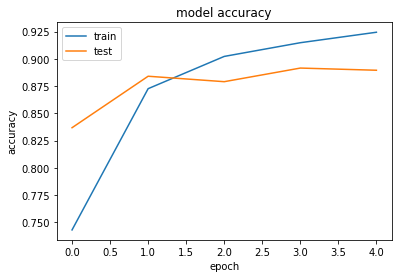

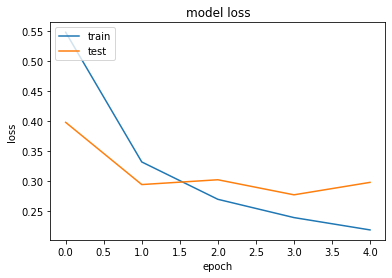

In [ ]:
# accuracy:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights('./RNN')

#model.load_weights('./RNN')

In [ ]:
Test_pred=model.predict(X_test)
y_pred=np.asarray(np.round(Test_pred).reshape(1,-1),dtype='int64')[0]

print('Test Accuracy: {:2.3}'.format(1-np.sum(np.abs(y_pred-y_test))/y_test.shape[0]))
print('Confusion matrix: ', np.array2string(confusion_matrix(y_test,y_pred), prefix='Confusion matrix: '))

313/313 [==============================] - 15s 42ms/step
Test Accuracy: 0.888
Confusion matrix:  [[4288  712]
                   [ 410 4590]]


In [ ]:
model.predict(table.lookup(preprocess_data([b'This movie is not good', b"This movie isn't good", b"This movie is awful", b"This movie could be amazing if it wasn't bad"])))

1/1 [==============================] - 0s 19ms/step


array([[0.10332723],
       [0.2067515 ],
       [0.0326689 ],
       [0.23572882]], dtype=float32)

In [ ]:
X_train1,X_test1,y_train1, y_test1=train_test_split(all_data['review'], y,\
                                                    stratify=y, test_size=0.2, random_state=42) 

for x in np.where((np.round(y_pred)!=y_test))[0][:3]:
  new_sent=[]
  for w in X_test[x]:
    if w!=0 and w<10000:
      new_sent.append(truncated_dict[w])
  print(x,('positive' if y_test[x]==1 else 'negative'),Test_pred[x],
        X_test1.to_numpy()[x]
        )
  print([new_sent])

1 negative [0.9307486] The story of the bride fair is an amusing and engaging one, and it is to the filmmaker's credit that he sets out to portray rural Minnesotans with the same respect ordinarily reserved for Coast-dwellers. It is weird, though, to find an independent movie, the brainchild of a single person, that is as unambitious and cliché-ridden as a committee-brewed Hollywood potboiler.<br /><br />The portrait of rural people is intended to be affectionate, I think, but these characters don't ring true to me--I have had quite a few meals in small-town diners, but never overheard a debate on the merits of different nineteenth-century English novelists. One might suggest that writer/director Semans has no more experience with rural culture than the Coen brothers, and considerably less satiric verve.
[[b'of', b'bride', b'fair', b'one', b'credit', b'that', b'he', b'out', b'portray', b'rural', b'respect', b'weird', b'though', b'find', b'of', b'person', b'that', b'clich', b'ridden', b

### Conclusions:

* We find a marked improvement in test accuracy to ~88-89% to Approach 0 by using an RNN. I tweaked various parameters but was not able to achieve better test-accuracy scores. Increasing the size of the model only starts to overfit, and it seems we would need more data to improve on the score with such models.
* It is interesting to see that negated sentences such as 'This movie is not good' get classified correctly (and well at that). This indeed shows that the RNN takes 'causal' structures into account. (We will see below that a purely word-sentiment type approach does not classify these types of statements correctly.)
* Finally, we test a few of the incorrectly classified reviews. From these, it is clear that the model struggles with more complex types of sentence structures. I assume it would require more data and a larger model to do so.



# Approach 2: Vectorize input + Logistic Regression/LGBM/...
 
In our second approach, we employ a standard bag-of-words model, where we map a given review to a 10000 dimensional (sparse) vector. A unit vector in this 10000 dimensional vector space encodes a word in a length-10000 dictionary (of the most common words appearing in the training set). Again, we are careful to define the dictionary only based on the training data.

On this prepared data we then apply 4 different models (**Logistic Regression**, **Decision Trees**, **Naive Bayes** and **Light GBM**). Both Logistic Regression and LGBM achieve relatively high scores (88%,89% test accuracy).
 
**Remarks/Conclusions:**
 
*  With this type of approach we lose the "causal" structure of a sentence/review, and we are solely interested in an "averaged" score of word sentiments within a review.
*  In particular, this means that a model trained on this input will predict a sentiment score for any word in the 10000 dimensional dictionary -- i.e. it will output a probability that a given word is found in a positive/negative review.
* As we shall see below, this type of approach will not be able to discern a sentence like "this movie is not good", as "not" naturally has a sentiment score of ~0.5. One attempt to account for such types of sentences is to add negated combinations such as "not good" to the dictionary as "not_good". This will then receive a negative sentiment score. However, then problems arise with combinations such as "not very good". I've implemented a few such approaches "by hand" but was not able to achieve significantly improved test scores.
* Nonetheless, we achieve a score of ~88-89% test accuracy, which is similar to what we achieved in the RNN approach (which does respect causal structures of a sentence).


In [ ]:
def pos_neg(x):
  return 1 if x=='positive' else 0

#all_data['y'] = all_data['sentiment'].map(pos_neg).to_numpy()
y = all_data['sentiment'].map(pos_neg).to_numpy()

In [ ]:
negating_words = set(['not','no','nt','t'])
stopword_set_neg = list(stopword_set-(negating_words))

In [ ]:
apply_stem=np.vectorize(lambda x: bytes(ps.stem(x.decode('utf-8')), 'utf-8'))

def preprocess_data_for_vec(X, nr_of_chars=100000, max_nr_of_words=1000):
  #X=tf.strings.substr(X,0,nr_of_chars)
  X=tf.strings.regex_replace(X,b"<br\\s*/?>",b" ")
  X=tf.strings.regex_replace(X,b"[^a-zA-Z']", b" ")
  X=tf.strings.regex_replace(X,b"'"," ")
  X=tf.strings.lower(X)
  X=tf.strings.regex_replace(X, r'\b(' + r'|'.join(stopword_set_neg) + r')\b\s*',"")
  return X

In [ ]:
processed_review_for_vec = preprocess_data_for_vec(all_data['review'])

In [ ]:
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(processed_review_for_vec.numpy(), y,\
                                                    stratify=y, test_size=0.2, random_state=42)  

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 10000)

X_train_v = vectorizer.fit_transform(X_train_v).toarray()
X_test_v = vectorizer.transform(X_test_v).toarray()

## a.) Logistic Regression (87.9% test accuracy)

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(max_iter=100) #max_iter=500
logistic_reg.fit(X_train_v, y_train_v)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred_v = logistic_reg.predict(X_test_v)

In [ ]:
#print('Train Accuracy: {:2.2}'.format(1-np.sum(np.abs(logistic_reg.predict(X_train_v)-y_train_v))/y_train_v.shape[0]))
print('Test Accuracy: {:2.3}'.format(1-np.sum(np.abs(y_pred_v-y_test_v))/y_test_v.shape[0]))
print('Confusion matrix: ', np.array2string(confusion_matrix(y_test_v,y_pred_v), prefix='Confusion matrix: '))

Test Accuracy: 0.879
Confusion matrix:  [[4380  620]
                   [ 587 4413]]


**Rmk:**  As we see below, negated phrases such as "this movie is not bad" and  "this movie is not very good" are misclassified with this approach.

In [ ]:
phrases=["This movie is not bad","This film is not very good","This movie isn't bad"]
pr_pred=logistic_reg.predict(vectorizer.transform(preprocess_data_for_vec(phrases).numpy()))
pr_pred_probab=logistic_reg.predict_proba(vectorizer.transform(preprocess_data_for_vec(phrases).numpy()))

def predfn(x): 
  if x==1:
    return 'positive'
  else:
    return 'negative'

print(f'Phrases: {[phrase for phrase in phrases]}')
print(f'Prediction for phrases: {[predfn(x) for x in pr_pred]}')
print(f'Prediction probability for phrases: {[round(x,3) for x in pr_pred_probab[:,1].tolist()]}')

Phrases: ['This movie is not bad', 'This film is not very good', "This movie isn't bad"]
Prediction for phrases: ['negative', 'positive', 'negative']
Prediction probability for phrases: [0.287, 0.548, 0.331]


## b.) Decision Trees (72% test accuracy)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train_v, y_train_v)

DecisionTreeClassifier()

In [ ]:
y_pred_v = dec_tree.predict(X_test_v)

print('Train Accuracy: {:2.2}'.format(1-np.sum(np.abs(dec_tree.predict(X_train_v)-y_train_v))/y_train_v.shape[0]))
print('Test Accuracy: {:2.2}'.format(1-np.sum(np.abs(y_pred_v-y_test))/y_test_v.shape[0]))
print('Confusion matrix: ', np.array2string(confusion_matrix(y_test_v,y_pred_v), prefix='Confusion matrix: '))

Train Accuracy: 1.0
Test Accuracy: 0.72
Confusion matrix:  [[3642 1358]
                   [1394 3606]]


## c.) Naive Bayes (72% test accuracy)

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_v, y_train_v)

GaussianNB()

In [ ]:
y_pred_v = gnb.predict(X_test_v)

print('Train Accuracy: {:2.2}'.format(1-np.sum(np.abs(gnb.predict(X_train_v)-y_train_v))/y_train_v.shape[0]))
print('Test Accuracy: {:2.2}'.format(1-np.sum(np.abs(y_pred_v-y_test_v))/y_test_v.shape[0]))
print('Confusion matrix: ', np.array2string(confusion_matrix(y_test_v,y_pred_v), prefix='Confusion matrix: '))

Train Accuracy: 0.77
Test Accuracy: 0.72
Confusion matrix:  [[4285  715]
                   [2063 2937]]


## d.) Light GBM (89.6% test accuracy)

In [ ]:
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV

In [ ]:
lgbm_model = LGBMClassifier()

In [ ]:
parameters = {
  'n_estimators': [100, 200, 500],
  'num_leaves': [7, 15, 31, 63, 127]
}

gsearch_lgb = GridSearchCV(LGBMClassifier(random_state=0), parameters, scoring = 'accuracy', cv = 5)
gsearch_lgb.fit(X_train_v,y_train_v)


In [ ]:
print('best params')
print (gsearch_lgb.best_params_)
preds_lgb_model = gsearch_lgb.predict(X_test_v)
#rmse_lgb = np.sqrt(mean_squared_error(y_test_v, preds_lgb_model))
#print(" RMSE: %f" % (rmse_lgb ))

best params
{'n_estimators': 500, 'num_leaves': 127}


In [ ]:
params = {'n_estimators': 500,'num_leaves' : 127}

gbm = LGBMClassifier(**params).fit(X_train_v, y_train_v)
#gbm = LGBMClassifier().fit(X_train_v, y_train_v)

In [ ]:
y_pred_vgbm = gbm.predict(X_test_v)

print('Train Accuracy: {:2.3}'.format(1-np.sum(np.abs(gbm.predict(X_train_v)-y_train_v))/y_train_v.shape[0]))
print('Test Accuracy: {:2.3}'.format(1-np.sum(np.abs(y_pred_vgbm-y_test_v))/y_test_v.shape[0]))
print('Confusion matrix: ', np.array2string(confusion_matrix(y_test_v,y_pred_vgbm), prefix='Confusion matrix: '))

Train Accuracy: 1.0
Test Accuracy: 0.896
Confusion matrix:  [[4472  528]
                   [ 512 4488]]


In [ ]:
y_pred_vgbm_proba = gbm.predict_proba(X_test_v)[:,1]

 
# Approach 3: Combine three different models (91% test accuracy)
 
In Approach 1, we trained a model with causal structures while in Approach 2, we
train models solely on the words in their reviews. It is natural to combine the two approaches ('ensemble learning'). We weigh the probability predictions arising from the Logistic Regression, the LGBM and the RNN model equally (1/3 each) and predict according to the aggregated score. By doing so, we achieve an improved score of 91% test accuracy.

## 1/3 * RNN+1/3 * Logistic+1/3 * LGBM

In [ ]:
y_pred_vlogistic_proba = logistic_reg.predict_proba(X_test_v)[:,1]

test_pred_perc=Test_pred.reshape(1,-1)[0]

y_pred_together=np.array([round(y_pred_vlogistic_proba[i]/3+test_pred_perc[i]/3+y_pred_vgbm_proba[i]/3) for i in range(10000)])

In [ ]:
# 1:1:1 weighting

print('Test Accuracy: {:2.6}'.format(1-np.sum(np.abs(y_pred_together-y_test))/y_test.shape[0]))

Test Accuracy: 0.9103


# Approach 4: Reusing Pretrained Embedding
 
In this approach we build upon already existing/pre-trained word-embeddings. In particular, we focus on two existing models:
 
1. **nnlm-en-dim50:** A relatively small embedding mapping sentences/reviews to a 50 dimensional vector.
2. **universal-sentence-encoder:** A somewhat larger embedding, mapping to 1000 dimensional vectors.


In [ ]:
import tensorflow_hub as hub

In [ ]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")

In [ ]:
embed_large = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

## a.) nnlm-en-dim50 + logistic regression (77% test accuracy)

In [ ]:
embeddings = embed(processed_review_for_vec)

X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(embeddings.numpy(), y,\
                                                    stratify=y, test_size=0.2, random_state=42)  

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

X_train_emb=scaler.fit_transform(X_train_emb)
X_test_emb=scaler.fit_transform(X_test_emb)

logistic_reg_emb = LogisticRegression() #max_iter=500
logistic_reg_emb.fit(X_train_emb, y_train_emb)

LogisticRegression()

In [ ]:
y_pred_emb = logistic_reg_emb.predict(X_test_emb)

print('Train Accuracy: {:2.2}'.format(1-np.sum(np.abs(y_pred_emb-y_test_emb))/y_test_emb.shape[0]))
print('Test Accuracy: {:2.2}'.format(1-np.sum(np.abs(y_pred_emb-y_test_emb))/y_test_emb.shape[0]))
print('Confusion matrix: ', np.array2string(confusion_matrix(y_test_emb,y_pred_emb), prefix='Confusion matrix: '))

Train Accuracy: 0.77
Test Accuracy: 0.77
Confusion matrix:  [[3845 1155]
                   [1169 3831]]


## b.) universal-sentence-encoder + logistic regression (84% test accuracy)

In [ ]:
embeddings_large = embed_large(processed_review_for_vec[:25000])

In [ ]:
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(embeddings_large.numpy(), y[:25000],\
                                                    stratify=y[:25000], test_size=0.2, random_state=42)  

In [ ]:
scaler=StandardScaler()

X_train_emb=scaler.fit_transform(X_train_emb)
X_test_emb=scaler.fit_transform(X_test_emb)

logistic_reg_emb = LogisticRegression() #max_iter=500
logistic_reg_emb.fit(X_train_emb, y_train_emb)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred_emb = logistic_reg_emb.predict(X_test_emb)

#print('Train Accuracy: {:2.2}'.format(1-np.sum(np.abs(y_pred_emb-y_test_emb))/y_test_emb.shape[0]))
print('Test Accuracy: {:2.2}'.format(1-np.sum(np.abs(y_pred_emb-y_test_emb))/y_test_emb.shape[0]))
print('Confusion matrix: ', np.array2string(confusion_matrix(y_test_emb,y_pred_emb), prefix='Confusion matrix: '))

Test Accuracy: 0.84
Confusion matrix:  [[2068  437]
                   [ 384 2111]]


## c.) universal-sentence-encoder + basic NN (87% test accuracy)

In [ ]:
model_dim50 = keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                  dtype=tf.string, input_shape=[]),
  #keras.layers.Dense(512,activation='relu'),
  #keras.layers.Dropout(rate=0.2),
  #keras.layers.Dense(256,activation='relu'),
  #keras.layers.Dropout(rate=0.2),
  keras.layers.Dense(128,activation='relu'),
  keras.layers.Dropout(rate=0.2),
  keras.layers.Dense(1, activation = "sigmoid")
])
model_dim50.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [ ]:
model_dim50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
#X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(processed_review_for_vec.numpy(), y,\
#                                                    stratify=y, test_size=0.2, random_state=42)  

X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(np.array(all_data['review']), y,\
                                                    stratify=y, test_size=0.2, random_state=42)  

X_train_v1 = tf.convert_to_tensor(X_train_v)
X_test_v1 = tf.convert_to_tensor(X_test_v)
y_train_v1 = tf.convert_to_tensor(y_train_v)
y_test_v1 = tf.convert_to_tensor(y_test_v)

In [ ]:
history = model_dim50.fit(X_train_v1, y_train_v1, validation_split=0.1, shuffle=True, epochs=10)

Epoch 1/10
1125/1125 [==============================] - 51s 43ms/step - loss: 0.3592 - accuracy: 0.8438 - val_loss: 0.3166 - val_accuracy: 0.8673
Epoch 2/10
1125/1125 [==============================] - 48s 43ms/step - loss: 0.3237 - accuracy: 0.8593 - val_loss: 0.3117 - val_accuracy: 0.8650
Epoch 3/10
1125/1125 [==============================] - 47s 42ms/step - loss: 0.3156 - accuracy: 0.8626 - val_loss: 0.3081 - val_accuracy: 0.8687
Epoch 4/10
1125/1125 [==============================] - 47s 42ms/step - loss: 0.3087 - accuracy: 0.8660 - val_loss: 0.3028 - val_accuracy: 0.8727
Epoch 5/10
1125/1125 [==============================] - 47s 42ms/step - loss: 0.3005 - accuracy: 0.8706 - val_loss: 0.3026 - val_accuracy: 0.8690
Epoch 6/10
1125/1125 [==============================] - 48s 42ms/step - loss: 0.2930 - accuracy: 0.8742 - val_loss: 0.2983 - val_accuracy: 0.8725
Epoch 7/10
1125/1125 [==============================] - 48s 42ms/step - loss: 0.2864 - accuracy: 0.8794 - val_loss: 0.2956 -

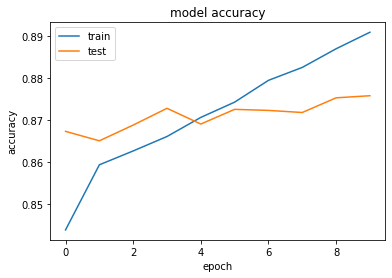

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

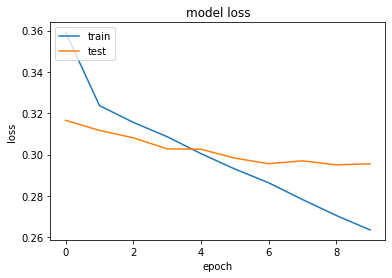

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Test_pred=model_dim50.predict(X_test_v1)
y_test_pred=np.asarray(np.round(Test_pred).reshape(1,-1),dtype='int64')[0]

Train_pred=model_dim50.predict(X_train_v1)
y_train_pred=np.asarray(np.round(Train_pred).reshape(1,-1),dtype='int64')[0]

1250/1250 [==============================] - 46s 37ms/step


In [ ]:
print('Train Accuracy: {:2.2}'.format(1-np.sum(np.abs(y_train_pred-y_train_v))/y_train_v.shape[0]))
print('Test Accuracy: {:2.2}'.format(1-np.sum(np.abs(y_test_pred-y_test_v))/y_test_v.shape[0]))
print('Confusion matrix: ', np.array2string(confusion_matrix(y_test_v,y_test_pred), prefix='Confusion matrix: '))

Train Accuracy: 0.9
Test Accuracy: 0.87
Confusion matrix:  [[4403  597]
                   [ 697 4303]]


# Approach 5: Combine Approaches 1, 2 and 4: (91.4% test accuracy)
 
As in approach 3, we now combine the most successful approaches to find a "final model" with test accuracy **91.4%**. We combine the RNN prediction of approach 1 with the logistic regression and LGBM models of approach 2 as well as the universal-sentence-encoder + basic NN model of approach 4 (with equal 1:1:1:1 weighing).


In [ ]:
y_pred_together_all = np.array([round(y_pred_vlogistic_proba[i]/4+test_pred_perc[i]/4+y_pred_vgbm_proba[i]/4+Test_pred.reshape(1,-1)[0][i]/4) for i in range(10000)])

# 1:1:1:1 weighting

print('Test Accuracy: {:2.6}'.format(1-np.sum(np.abs(y_pred_together_all-y_test))/y_test.shape[0]))

Test Accuracy: 0.9141


# Approach 6 (experimental): Include causal structure in vectorization:

Here -- for completion -- we include some additional, more experimental ideas that I played around with.

## a.) Include 'not'+word for negation
 
As mentioned in Approach 4, we can try to account for negating phrases by (naively) adding not+word to the dictionary. For example if the review contains a phrase such as "isn't good" we add "is" and "notgood" to the dictionary. This accounts for very simple negating phrases but not for more complex one (for that one would need to use more sophisticated approaches).

We do not find significant improvement by doing so. Actually, the test accuracy for the lgbm model remains the same as before.

In [ ]:
processed_review_for_vec_new=[]

for sentence in processed_review_for_vec:
  prev=''
  new_sent=[]
  for word in tf.strings.split(sentence):
    word_str=word.numpy().decode("utf-8")
    
    if word_str in negating_words:
      prev=word_str
    else:
      if prev=='':
        new_sent.append(ps.stem(word_str))
      else:
        new_sent.append('not'+ps.stem(word_str))
        prev=''
  processed_review_for_vec_new.append(bytes(" ".join(new_sent), 'utf-8'))

In [ ]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(np.array(processed_review_for_vec_new), y,\
                                                    stratify=y, test_size=0.2, random_state=42)  

In [ ]:
vectorizer_new = CountVectorizer(max_features = 1000)

X_train_new = vectorizer.fit_transform(X_train_new).toarray()
X_test_new = vectorizer.transform(X_test_new).toarray()

### i.) Light GBM (89% test accuracy)

In [ ]:
new_params = {'n_estimators': 500,'num_leaves' : 31}

new_gbm = LGBMClassifier(**new_params).fit(X_train_new, y_train_new)
#gbm = LGBMClassifier().fit(X_train_v, y_train_v)

In [ ]:
y_pred_vgbm_new = new_gbm.predict(X_test_new)

print('Train Accuracy: {:2.3}'.format(1-np.sum(np.abs(new_gbm.predict(X_train_new)-y_train_new))/y_train_new.shape[0]))
print('Test Accuracy: {:2.3}'.format(1-np.sum(np.abs(y_pred_vgbm_new-y_test_new))/y_test_new.shape[0]))
print('Confusion matrix: ', np.array2string(confusion_matrix(y_test_new,y_pred_vgbm_new), prefix='Confusion matrix: '))

In [ ]:
new_params = {'n_estimators': 500,'num_leaves' : 127}

new_gbm = LGBMClassifier(**new_params).fit(X_train_new, y_train_new)
#gbm = LGBMClassifier().fit(X_train_v, y_train_v)

In [ ]:
y_pred_vgbm_new = gbm_new.predict(X_test_new)

print('Train Accuracy: {:2.3}'.format(1-np.sum(np.abs(gbm_new.predict(X_train_new)-y_train_new))/y_train_new.shape[0]))
print('Test Accuracy: {:2.3}'.format(1-np.sum(np.abs(y_pred_vgbm_new-y_test_new))/y_test_new.shape[0]))
print('Confusion matrix: ', np.array2string(confusion_matrix(y_test_new,y_pred_vgbm_new), prefix='Confusion matrix: '))

Train Accuracy: 1.0
Test Accuracy: 0.896
Confusion matrix:  [[4472  528]
                   [ 512 4488]]


**Rmk:** The below example shows that a phrase such as "this movie is not bad" is now classified correctly, since "not bad" is encoded as "notbad" in the dictionary with positive sentiment score.

In [ ]:
new_gbm.predict_proba(vectorizer.transform(np.array([b'notbad'])).toarray())

array([[0.38780372, 0.61219628]])

# b.) Bag-of-words sentiment + RNN

This is another attempt to add causal structure to the vectorized bag-of-word input of Approach 2. In particular, we now use the pre-trained logistic regression (or lgbm) model to assign a sentiment score for each of the first 100 words in a review. We then take these sentiment vectors and train a RNN model on them. 

**Rmks:**

* The upshot is that once we processed the input, the model is extremely fast. 
* To me this is a novel idea (I have not encountered an approach like this). Tuning various parameters (in particular the number of words we keep) I was able to achieve up to ~85% test accuracy -- which is a slight improvement over the baseline. However, training seems quite erratic and prone to changes of parameters. I suspect including more words might yield a somewhat higher score.
* I wonder if this approach is actually able to improve over approach 2 (which we use as an input). One issue is that negated phrases are still classified incorrectly. For example, the model in approach 2 maps 'not' and 'very' to ~0.5 sentiment score. Thus, the current model will not be able to discern 'not good' from 'very good', as both their inputs account for a similar sequence of ~ [...., 0.5, 0.8, ...] in the input vector.


In [ ]:
def fn_gbm(x):
  return gbm.predict_proba(vectorizer.transform(x).toarray())[:,1]

def fn_log(x):
  return logistic_reg.predict_proba(vectorizer.transform(x).toarray())[:,1]


def process_for_sentiment(X, max_nr_of_words=1000, method='log'):
  X = tf.strings.split(X)
  X = X.to_tensor(shape=[None,max_nr_of_words])
  if method=='gbm':
    X = np.apply_along_axis(fn_gbm,1,X.numpy())
  else: # method=='log':
    X = np.apply_along_axis(fn_log,1,X.numpy())
  return X

In [ ]:
MAX_NR_OF_WORDS = 100
NR_OF_SAMPLES = 50000

processed_review_for_vec_num = process_for_sentiment(processed_review_for_vec[:NR_OF_SAMPLES],\
                                                     max_nr_of_words=MAX_NR_OF_WORDS,
                                                     method='log')

y_num = y[:NR_OF_SAMPLES]

In [ ]:
from sklearn.preprocessing import StandardScaler

scal= StandardScaler()
processed_review_for_vec_num_scal = scal.fit_transform(processed_review_for_vec_num)

X_train_gbm, X_test_gbm, y_train_gbm, y_test_gbm = train_test_split(processed_review_for_vec_num_scal, y_num,\
                                                    stratify=y_num, test_size=0.2, random_state=42)  

In [ ]:
embed_size = 128

model_gbm = keras.models.Sequential([
  keras.layers.Embedding(MAX_NR_OF_WORDS,
                          embed_size,
                          #mask_zero = True, 
                          input_shape = [None]),
  #keras.layers.Dropout(rate=0.2),
  keras.layers.GRU(128, return_sequences = True),
  #keras.layers.Dropout(rate=0.2),
  keras.layers.GRU(128),
  #keras.layers.Dropout(rate=0.2),
  keras.layers.Dense(1, activation = "sigmoid")
])

opt=keras.optimizers.Adam(learning_rate=0.0001)

model_gbm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history_gbm = model_gbm.fit(X_train_gbm, y_train_gbm,\
                    validation_split = 0.1,\
                    shuffle = True,\
                    epochs = 10)

Epoch 1/10
1125/1125 [==============================] - 15s 12ms/step - loss: 0.5780 - accuracy: 0.6407 - val_loss: 0.3601 - val_accuracy: 0.8357
Epoch 2/10
1125/1125 [==============================] - 14s 12ms/step - loss: 0.2914 - accuracy: 0.8730 - val_loss: 0.2834 - val_accuracy: 0.8802
Epoch 3/10
1125/1125 [==============================] - 13s 12ms/step - loss: 0.2839 - accuracy: 0.8751 - val_loss: 0.2830 - val_accuracy: 0.8733
Epoch 4/10
1125/1125 [==============================] - 13s 12ms/step - loss: 0.2819 - accuracy: 0.8752 - val_loss: 0.2829 - val_accuracy: 0.8770
Epoch 5/10
1125/1125 [==============================] - 13s 11ms/step - loss: 0.2801 - accuracy: 0.8777 - val_loss: 0.2768 - val_accuracy: 0.8777
Epoch 6/10
1125/1125 [==============================] - 12s 11ms/step - loss: 0.2783 - accuracy: 0.8769 - val_loss: 0.2834 - val_accuracy: 0.8780
Epoch 7/10
1125/1125 [==============================] - 13s 12ms/step - loss: 0.2770 - accuracy: 0.8782 - val_loss: 0.2841 -

In [ ]:
y_pred_gbmTest_pred_gbm = model_gbm.predict(X_test_gbm)
y_pred_gbm = np.asarray(np.round(Test_pred_gbm).reshape(1,-1),dtype='int64')[0]

print('Test Accuracy: {:2.3}'.format(1-np.sum(np.abs(y_pred_gbm-y_test_gbm))/y_test_gbm.shape[0]))
print('Confusion matrix: ', np.array2string(confusion_matrix(y_test_gbm,y_pred_gbm), prefix='Confusion matrix: '))

313/313 [==============================] - 2s 5ms/step
Test Accuracy: 0.826
Confusion matrix:  [[4103  897]
                   [ 841 4159]]
